In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from scipy.special import gamma
warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)
os.makedirs('../models',exist_ok=True)

sns.set_theme('paper')

data = pd.read_csv('../data/Heart_Disease.csv')

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Spliting the data


In [3]:
X = data.drop('target',axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and evaluating baseline KNN model

In [4]:
sns.set_theme(style='whitegrid')
def train_evaluate_knn(X_train,X_test,y_train,y_test ,scaling=False, **kwargs):
    if scaling:
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        X_test_scaled= scaler.transform(X_test)
        print("\nRunning KNN with scaling.")
        X_train_use ,X_test_use = X_train_scaled, X_test_scaled
    else:
        print("\nRunning KNN without scaling.")
        X_train_use ,X_test_use = X_train, X_test

    knn_model = KNeighborsClassifier(**kwargs)
    knn_model.fit(X_train_use,y_train)

    y_pred = knn_model.predict(X_test_use)
    y_prob = knn_model.predict_proba(X_test_use)[:,1] # type: ignore

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()
    cv_auc = cross_val_score(knn_model, X_train_use, y_train, cv=5, scoring='roc_auc').mean()

    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\nAccuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")
    print(f"AUC (Test): {auc:.4f} | CV-AUC: {cv_auc:.4f}")
    
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", clr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}.png', dpi=300)
    plt.close()

    return{
        'model':knn_model,
        'scaler':scaler if scaling else None,
        'X_train_use':X_train_use,
        'X_test_use':X_test_use,
        'Accuracy':acc,
        'F1':f1,
        'AUC': auc,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'CV_AUC': cv_auc,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

In [5]:
print("****** Results of the Baseline KNN Model ******")
result_unscaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=False)
result_scaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=True)

****** Results of the Baseline KNN Model ******

Running KNN without scaling.

Accuracy (Test): 0.7017 | CV: 0.7049
F1-Score (Test): 0.7280 | CV: 0.7255
AUC (Test): 0.6984 | CV-AUC: 0.7553

Confusion Matrix:
 [[72 40]
 [31 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       112
           1       0.70      0.75      0.73       126

    accuracy                           0.70       238
   macro avg       0.70      0.70      0.70       238
weighted avg       0.70      0.70      0.70       238


Running KNN with scaling.

Accuracy (Test): 0.8361 | CV: 0.8488
F1-Score (Test): 0.8494 | CV: 0.8575
AUC (Test): 0.8338 | CV-AUC: 0.9042

Confusion Matrix:
 [[ 89  23]
 [ 16 110]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.83      0.87      0.85       126

    accuracy                           0.84       

# OOA Implementation (adapted from Octopus Optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [6]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin((np.pi * beta)/2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * ((u * sigma) / (np.abs(v) ** (1/beta)))

    return step

In [12]:
sns.set_theme('paper')

def ooa_optimize(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10):
    np.random.seed(42)
    pop = np.random.uniform(lb,ub,(N,dim))
    fitness = np.array([obj_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]
    history = [-best_fit]

    vr , ll = 3, 0.8

    for t in range(1,max_iter +1):
        for i in range(Nh):
            trans = (2 * np.random.rand() -1) * vr * (1-t / max_iter)
            if abs(trans) < ll:
                new_pos = pop[i] + np.random.rand() * (best_pos - pop[i]) * levy_flight(dim)
                new_pos = np.clip(new_pos,lb,ub)
                new_fit = obj_func(new_pos)
                if new_fit < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fit
                    if new_fit < best_fit:
                        best_pos, best_fit = new_pos,new_fit
        
        for i in range(Nh, N):
            new_pos = pop[i] + (2 * np.random.rand(dim) - 1) * (ub - lb)  * (1-t / max_iter)
            new_pos = np.clip(new_pos, lb, ub)
            new_fit = obj_func(new_pos)
            if new_fit < fitness[i]:
                pop[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fit:
                    best_pos, best_fit = new_pos, new_fit
        
        history.append(-best_fit)
        
        if t%20 ==0:
            print(f"Iter {t}: Best CV Acc ={-best_fit:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.title(f'Fitness Evaluation during {max_iter} iterations')
    plt.savefig('../results/fitness_evaluation.png', dpi=300)
    plt.show()

    return best_pos , best_fit

In [8]:
def ensure_array(x, dim):
    x = np.asarray(x, dtype=float)
    if x.shape == (dim,):
        return x
    raise ValueError("Position must have shape (dim,)")

def ooa_optimizer(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10, seed=42, vr=3, ll=0.8, verbose=True):
    """
    OOA with explicit Hunters (head + 8 tentacles) and Scouts.
    Minimization problem: lower fitness is better.
    """
    np.random.seed(seed)

    # Basic checks
    if Nh <= 0 or Ns < 0 or Nh + Ns > N:
        raise ValueError("Invalid Nh/Ns: require Nh>0, Ns>=0 and Nh+Ns <= N")

    # Initialize hunter heads (first Nh) and scouts (remaining)
    pop = np.random.uniform(lb, ub, size=(N, dim))
    fitness = np.array([obj_func(ind) for ind in pop])

    # Build hunters: each hunter keeps head + 8 tentacles and associated fitness
    hunters = []
    for i in range(Nh):
        head = pop[i].copy()
        head_fit = fitness[i]
        # eight tentacles initialised around head within +/- ll
        tentacles = head + np.random.uniform(-ll, ll, size=(8, dim))
        tent_fits = np.array([obj_func(t) for t in tentacles])
        hunters.append({
            "head": head,
            "head_fit": head_fit,
            "tentacles": tentacles,
            "tent_fits": tent_fits
        })

    # Scouts are the remaining individuals (index mapping)
    scout_indices = list(range(Nh, N))

    # Best global
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    history = [best_fit]

    for t in range(1, max_iter + 1):
        ld = vr * (1.0 - t / max_iter)  # exploration length decreases
        # --- Update hunters (tentacles + head) ---
        for i, hunter in enumerate(hunters):
            head = hunter["head"]
            old_head = head.copy()
            # one tentacle retains previous head as short-term memory
            mem_idx = 0
            hunter["tentacles"][mem_idx] = old_head.copy()
            hunter["tent_fits"][mem_idx] = hunter["head_fit"]

            for j in range(8):
                tent = hunter["tentacles"][j].copy()
                trans = (2 * np.random.rand() - 1) * ld
                if abs(trans) < ll:
                    # grab toward prey (best_pos) with Levy perturbation (Eq.12 idea)
                    step = np.random.rand() * (best_pos - tent) * levy_flight(dim)
                    new_tent = tent + step
                else:
                    # move relative to head (Eq.15 idea)
                    step = np.random.rand(dim) * (hunter["head"] - tent) * levy_flight(dim)
                    new_tent = hunter["head"] + step

                # clip and evaluate
                new_tent = np.clip(new_tent, lb, ub)
                new_fit = obj_func(new_tent)

                # accept if better
                if new_fit < hunter["tent_fits"][j]:
                    hunter["tentacles"][j] = new_tent
                    hunter["tent_fits"][j] = new_fit

            # after tentacles updated, update head if any tentacle is better
            best_tent_idx = np.argmin(hunter["tent_fits"])
            if hunter["tent_fits"][best_tent_idx] < hunter["head_fit"]:
                hunter["head"] = hunter["tentacles"][best_tent_idx].copy()
                hunter["head_fit"] = hunter["tent_fits"][best_tent_idx]

            # update global best if needed
            if hunter["head_fit"] < best_fit:
                best_fit = hunter["head_fit"]
                best_pos = hunter["head"].copy()

        # --- Generate/Update scouts ---
        # choose Ns positions: best, worst and Ns-2 random hunter heads (as paper)
        hunter_heads = np.array([h["head"] for h in hunters])
        hunter_head_fits = np.array([h["head_fit"] for h in hunters])

        # get best and worst hunter indices
        best_h_idx = np.argmin(hunter_head_fits)
        worst_h_idx = np.argmax(hunter_head_fits)

        chosen_heads = []
        chosen_indices = []
        if Ns > 0:
            chosen_heads.append(hunter_heads[best_h_idx].copy())
            chosen_indices.append(best_h_idx)
            if Ns > 1:
                chosen_heads.append(hunter_heads[worst_h_idx].copy())
                chosen_indices.append(worst_h_idx)
            # fill remaining with random hunters (without replacement)
            remaining = Ns - len(chosen_heads)
            if remaining > 0:
                pool = [i for i in range(len(hunters)) if i not in chosen_indices]
                sel = list(np.random.choice(pool, size=remaining, replace=False))
                for s in sel:
                    chosen_heads.append(hunter_heads[s].copy()); chosen_indices.append(s)

            # create scouts based on chosen_heads (Eq.16 style)
            scouts = []
            for ch in chosen_heads:
                # Scoutz = Huntersz:head + rand * ld * ( (UB+LB)/2 - Huntersz:head )
                center = (np.array(ub) + np.array(lb)) / 2.0
                new_pos = ch + np.random.rand(dim) * ld * (center - ch)
                new_pos = np.clip(new_pos, lb, ub)
                scouts.append(new_pos)

            # evaluate and convert if better
            for sc_pos, h_idx in zip(scouts, chosen_indices):
                sc_fit = obj_func(sc_pos)
                if sc_fit < hunters[h_idx]["head_fit"]:
                    # convert scout to hunter head and regenerate 8 tentacles around it (Eq.17-18 idea)
                    hunters[h_idx]["head"] = sc_pos.copy()
                    hunters[h_idx]["head_fit"] = sc_fit
                    new_tentacles = hunters[h_idx]["head"] + np.random.uniform(-ll, ll, size=(8, dim))
                    hunters[h_idx]["tentacles"] = np.clip(new_tentacles, lb, ub)
                    hunters[h_idx]["tent_fits"] = np.array([obj_func(t) for t in hunters[h_idx]["tentacles"]])

                    # update global best if needed
                    if sc_fit < best_fit:
                        best_fit = sc_fit
                        best_pos = sc_pos.copy()

        # --- record history ---
        history.append(best_fit)

        # optional progress
        if verbose and t % 20 == 0:
            print(f"Iter {t}: Best fitness = {best_fit:.6f}")

    # plot fitness history
    plt.figure(figsize=(8,5))
    plt.plot(history, marker='o', markersize=3)
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness (minimization)')
    plt.title(f'OOA fitness over {max_iter} iterations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_pos, best_fit


In [9]:
scaler_ooa = StandardScaler()
X_train_scaled = scaler_ooa.fit_transform(X_train)
X_test_scaled = scaler_ooa.transform(X_test)

In [10]:
metric_map = {1: 'euclidean', 2: 'manhattan', 3: 'chebyshev', 4:'Minkowski', 5:'Hamming', 6:'Cosine'}
weight_map = {1: 'uniform', 2: 'distance'}

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    metric_idx = int(np.clip(params[2], 1, 6))
    weight_idx = int(np.clip(params[3], 1, 2))

    metric = metric_map[metric_idx]
    weights = weight_map[weight_idx]

    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric=metric,weights=weights)  
    
    #cv on train for robust opt
    cv_acc = cross_val_score(knn,X_train_scaled,y_train,cv=5, scoring='accuracy').mean()

    return 1 - cv_acc


In [ ]:
lb = np.array([1,1,1,1])
ub = np.array([30,3,3,2])
dim = 4

print("\n**** OOA Optimazation (CV based) ****")
best_params, best_cv_acc = ooa_optimize(knn_objective,lb,ub,dim,N=30,max_iter=80) 
best_k, best_p, best_metric_idx, best_weight_idx  = int(best_params[0]),best_params[1],int(best_params[2]), int(best_params[3])

best_metric = metric_map[best_metric_idx]
best_weight = weight_map[best_weight_idx]

print(f"\nBest OOA Params : k={best_k}, p={best_p:.2f}, metric={best_metric},weights={best_weight}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")


**** OOA Optimazation (CV based) ****
Iter 20: Best CV Acc =-0.0935


In [ ]:
lb = np.array([1,1,1,1])
ub = np.array([30,3,3,2])
dim = 4

print("\n**** OOA Optimazation 2 (CV based) ****")
best_params, best_cv_acc = ooa_optimizer(knn_objective, lb, ub, dim, N=30, max_iter=80) 
best_k, best_p, best_metric_idx, best_weight_idx  = int(best_params[0]),best_params[1],int(best_params[2]), int(best_params[3])

best_metric = metric_map[best_metric_idx]
best_weight = weight_map[best_weight_idx]

print(f"\nBest OOA Params : k={best_k}, p={best_p:.2f}, metric={best_metric},weights={best_weight}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")

In [ ]:
# eval tuned on test 
knn_opt = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric=best_metric,weights=best_weight)
knn_opt.fit(X_train_scaled,y_train)

y_pred_opt = knn_opt.predict(X_test_scaled)
y_prob_opt = knn_opt.predict_proba(X_test_scaled)[:,1]

acc_opt = accuracy_score(y_test,y_pred_opt)
f1_opt = f1_score(y_test,y_pred_opt)
auc_opt = roc_auc_score(y_test, y_prob_opt)

cv_acc_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='accuracy').mean()
cv_f1_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='f1').mean()
cv_auc_opt = cross_val_score(knn_opt, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()

cm_opt = confusion_matrix(y_test, y_pred_opt)
clr_opt = classification_report(y_test, y_pred_opt)

In [25]:
#overfit checker
train_acc = accuracy_score(y_train,knn_opt.predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {acc_opt:.4f} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=1.0000  vs Test= 0.9538 (Diff < 0.05 -->ok)


In [26]:
print(f"\nOOA-KNN Test Acc:{acc_opt:.4f} | CV-acc: {cv_acc_opt:.4f}")
print(f"OOA-KNN Test F1:{acc_opt:.4f} | CV-f1: {cv_f1_opt:.4f}")
print(f"OOA-KNN Test AUC: {auc_opt:.4f} | CV-AUC: {cv_auc_opt:.4f}")


OOA-KNN Test Acc:0.9538 | CV-acc: 0.9065
OOA-KNN Test F1:0.9538 | CV-f1: 0.9124
OOA-KNN Test AUC: 0.9718 | CV-AUC: 0.9556


In [27]:
print("\nOOA Confusion Matrix:\n", cm_opt)
print("\nOOA Classification Report:\n", clr_opt)


OOA Confusion Matrix:
 [[107   5]
 [  6 120]]

OOA Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       112
           1       0.96      0.95      0.96       126

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



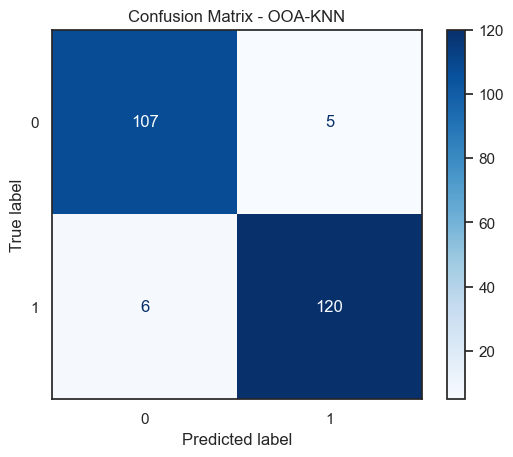

In [28]:
sns.set_theme(style='white')
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot(cmap='Blues')
plt.title('Confusion Matrix - OOA-KNN')
plt.savefig('../results/cm_ooa_knn.png', dpi=300)
plt.show()

In [29]:
#comparision table 
print("\n***** Performance Comparision ****")
comparison_data = {
    'Model': ['KNN Unscaled','KNN Scaled','OOA-KNN (Optimized)'],
    'Test Acc': [result_unscaled['Accuracy'], result_scaled['Accuracy'], acc_opt],
    'Test F1': [result_unscaled['F1'], result_scaled['F1'], f1_opt],
    'Test AUC':[result_unscaled['AUC'], result_scaled['AUC'], auc_opt],
    'CV Acc': [result_unscaled['CV_Acc'], result_scaled['CV_Acc'], cv_acc_opt],
    'CV F1': [result_unscaled['CV_F1'], result_scaled['CV_F1'], cv_f1_opt],
    'CV AUC':[result_unscaled['CV_AUC'], result_scaled['CV_AUC'], cv_auc_opt]
}
comparision = pd.DataFrame(comparison_data)
print(comparision.round(4))


***** Performance Comparision ****
                 Model  Test Acc  Test F1  Test AUC  CV Acc   CV F1  CV AUC
0         KNN Unscaled    0.7017   0.7280    0.6984  0.7049  0.7255  0.7553
1           KNN Scaled    0.8361   0.8494    0.8338  0.8488  0.8575  0.9042
2  OOA-KNN (Optimized)    0.9538   0.9562    0.9718  0.9065  0.9124  0.9556


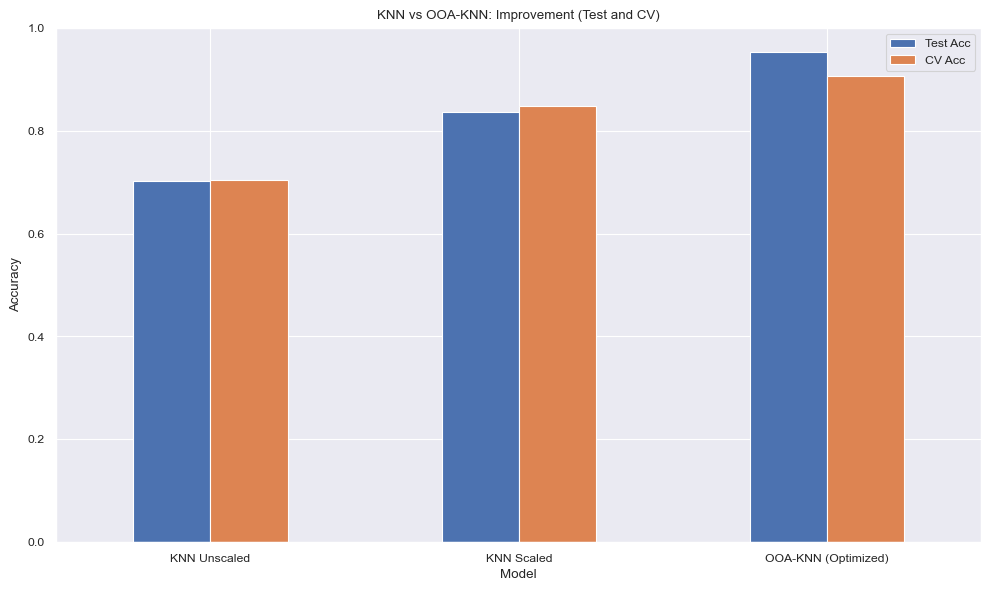

In [30]:
sns.set_theme('paper')
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar', figsize=(10,6))
plt.title('KNN vs OOA-KNN: Improvement (Test and CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.savefig('../results/performance_comparision.png', dpi=300)
plt.show()

In [21]:
joblib.dump(knn_opt, '../models/ooa_knn_model.joblib')

['../models/ooa_knn_model.joblib']